# Add multiple or single product(s) stored in external server (open-access storage) with a STAC Catalog

In this notebook, we walk through the process of:
- Finding an external open-access dataset (in this case, from Zenodo).
- Preparing a text file of TIFF file links.
- Creating STAC Items (one per TIFF file) using PySTAC.
- Creating a top-level STAC Catalog (`catalog.json`) and adding the Items to it.
- Storing (and optionally syncing) the STAC catalog to an S3 or other HTTP service.
- Adding a reference to the STAC catalog in your Open Science Data Catalog or similar portal.

In [1]:
# Install dependencies

#!pip install zenodo_get pystac rasterio rio_stac

In [2]:
import pystac
import os
from datetime import datetime

__Note:__ In this scenario, we have a set of TIFF images stored openly on Zenodo. The URL for the dataset is:

[https://zenodo.org/record/7568049](https://zenodo.org/record/7568049)

We want to generate a text file that contains the direct links to all `.tif` files in that record.

For Zenodo records, we can use `zenodo_get` with the `--wget` option to write all the download links to a .txt file.

In [3]:
# !zenodo_get "https://zenodo.org/record/7568049" -w tiff_links.txt

In [4]:
# Verifying that the links have been written to file correctly
!head -3 tiff_links.txt

https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20171111T205337_20171111T205438_008239_00E91A_F8D1.tif
https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20190224T203744_20190224T203844_015093_01C356_B9C1.tif
https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20170620T205332_20170620T205433_006139_00AC89_6857.tif


In [5]:
# Inspecting the number of unique records
!wc -l tiff_links.txt

      54 tiff_links.txt


# Creating our STAC items

STAC **Items** each represent a single granule (asset) in your dataset. Here, each TIFF file is one granule. We’ll loop through the list of URLs in `tiff_links.txt` and create a corresponding STAC Item.

The STAC Item should contain as much metadata as possible, such as the bounds, bands, projection, coordinate system, and more.

In this section we will create stac Items for our data assets, and show how to do this both manually and semi-automatically. There are many available tools that can help with this process, and it's worth to have a look if there are tools that can help you with your scenario!

## Manually creating a STAC Item
Here we will load one of our images in order to extract metadata.

You can think of STAC Items usually contain two main parts:
- Its own metadata, e.g. bounding box, geometry, bands, and more
- An Asset, which is a reference to the actual data file (link in our case)

In [6]:
import rasterio
from rasterio.plot import show

In [7]:
from pathlib import Path
# picking the last file among many
filenames = []

with open("tiff_links.txt", "r") as f:
    for line in f.readlines():
        if Path(line.strip()).suffix == ".tif":
            filenames.append(line.strip())
file_url = filenames[-1]
print(file_url)

https://zenodo.org/records/7568049/files/extent_S1A_EW_GRDH_1SDH_20170720T205416_20170720T205517_017560_01D5EF_DFAE.tif


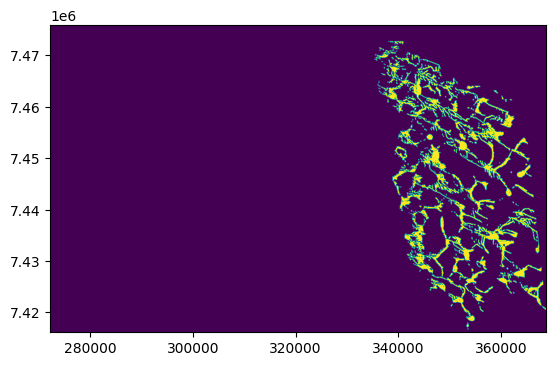

<Axes: >

In [8]:
# loading the .tif file into a raster object such that we can extract more information about the data
raster = rasterio.open(file_url)
show(raster)

These raster datasets include a lot of extra information, which is what we want to extract and add to our STAC Item. A minimal example would look like this:

In [9]:
from datetime import datetime

def bbox_to_geom(bbox: tuple[float, float, float, float]) -> dict:
    """Return a geojson geometry from a bbox."""
    return {
        "type": "Polygon",
        "coordinates": [
            [
                [bbox[0], bbox[1]],
                [bbox[2], bbox[1]],
                [bbox[2], bbox[3]],
                [bbox[0], bbox[3]],
                [bbox[0], bbox[1]],
            ]
        ],
    }

In [10]:
date_string = datetime.now()
bounding_box = list(raster.bounds)
geometry = bbox_to_geom(list(raster.bounds))
properties = {}


minimal_item = pystac.Item(
    id="item_1",
    datetime=datetime.now(),
    geometry=geometry,
    bbox=bounding_box,
    properties=properties
)

In [11]:
minimal_item.to_dict()

{'type': 'Feature',
 'stac_version': '1.1.0',
 'stac_extensions': [],
 'id': 'item_1',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[272312.5, 7416137.5],
    [368812.5, 7416137.5],
    [368812.5, 7475962.5],
    [272312.5, 7475962.5],
    [272312.5, 7416137.5]]]},
 'bbox': [272312.5, 7416137.5, 368812.5, 7475962.5],
 'properties': {'datetime': '2025-03-10T15:17:37.402288Z'},
 'links': [],
 'assets': {}}

This item has _some_ metadata about our data, but no reference to the data file yet, therefore we should add the asset.

In [12]:
data_href = file_url
media_type = "image/tiff"
roles = ["data"]

asset = pystac.Asset(
    href=data_href,
    media_type=media_type,
    roles=roles
)

asset

<Asset href=https://zenodo.org/records/7568049/files/extent_S1A_EW_GRDH_1SDH_20170720T205416_20170720T205517_017560_01D5EF_DFAE.tif>

Finally, we can add the asset to our item:

In [13]:
minimal_item.add_asset(
    key="data",
    asset=asset)

minimal_item

<Item id=item_1>

Now we have showed how you can manually create STAC Items from your raster data.

This was quite a cumbersome process, and it does not contain nearly enough information to be interoperable by your fellow scientists. The Item needs to contain more information about the projection, coordinate systems, bands, etc.

*The more the better!*

### Generating STAC Items with `rio_stac`
Now we will display how community tools can streamline the process of generating STAC items.

The library we will be using is made for creating STAC Items from raster datasets, and is called `rio_stac` [(documentation here)](https://developmentseed.org/rio-stac/api/rio_stac/stac/). This is a library which provides utility functions that iterate over all the metadata of our dataset for us, and returns a valid STAC object.

In [14]:
from rio_stac.stac import create_stac_item
import json

item = create_stac_item(raster, id="item_1", with_eo=True, with_proj=True, with_raster=True)

In [15]:
print(json.dumps(item.to_dict(), indent=2))

{
  "type": "Feature",
  "stac_version": "1.1.0",
  "stac_extensions": [
    "https://stac-extensions.github.io/projection/v1.1.0/schema.json",
    "https://stac-extensions.github.io/raster/v1.1.0/schema.json",
    "https://stac-extensions.github.io/eo/v1.1.0/schema.json"
  ],
  "id": "item_1",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          -50.17968937855544,
          66.77834561360399
        ],
        [
          -47.9894188361956,
          66.83503196763441
        ],
        [
          -48.056356656894216,
          67.37093506267574
        ],
        [
          -50.295235368856346,
          67.31275872920898
        ],
        [
          -50.17968937855544,
          66.77834561360399
        ]
      ]
    ]
  },
  "bbox": [
    -50.295235368856346,
    66.77834561360399,
    -47.9894188361956,
    67.37093506267574
  ],
  "properties": {
    "proj:epsg": 32623,
    "proj:geometry": {
      "type": "Polygon",
      "coordinates": [

That's it! With one line of code, we have generated a much richer Item with all the information we could need to perform operations on the data.

Notice how we have also included STAC extensions, namely the [eo](https://github.com/stac-extensions/eo), [projection](https://github.com/stac-extensions/projection), [raster](https://github.com/stac-extensions/raster) extensions. These extensions specifically provides handling of extra properties related to raster EO data.

<div class="alert alert-block alert-info">
    <b>Note: </b><a href=https://github.com/stac-extensions/raster>STAC-extensions</a> are a powerful addition to the STAC workflow, and you should always try to include additional information with the STAC extensions that fit your datasets! 
</div>

## Generating an item for every file
Before completing our entry in the STAC catalog, we need to generate an Item for every one of our 54 datasets.

Due to some request rate limits from the dataset provider, in this example we will first download all the files to a local folder to later open them with rasterio at our leisure. However, **the reference URLs need to point to the remote (and open) storage!**

In [16]:
data_dir = Path("local_files")
if not data_dir.exists():
    data_dir.mkdir()


In [17]:
!cd local_files && zenodo_get "https://zenodo.org/record/7568049"

Title: Supraglacial lakes derived from Sentinel-1 SAR imagery over the Watson basin on the Greenland Ice Sheet.
Keywords: Supraglacial lakes, SAR
Publication date: 2023-01-25
DOI: 10.5281/zenodo.7568049
Total size: 1.4 GB

Link: https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20171111T205337_20171111T205438_008239_00E91A_F8D1.tif   size: 18.5 MB
extent_S1B_EW_GRDH_1SDH_20171111T205337_20171111T205438_008239_00E91A_F8D1.tif is already downloaded correctly.

Link: https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20190224T203744_20190224T203844_015093_01C356_B9C1.tif   size: 7.8 MB
extent_S1B_EW_GRDH_1SDH_20190224T203744_20190224T203844_015093_01C356_B9C1.tif is already downloaded correctly.

Link: https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20170620T205332_20170620T205433_006139_00AC89_6857.tif   size: 18.5 MB
extent_S1B_EW_GRDH_1SDH_20170620T205332_20170620T205433_006139_00AC89_6857.tif is already downloaded correctly.

Link: https:/

extent_S1B_EW_GRDH_1SDH_20180320T202923_20180320T203023_010120_0125FB_84B6.tif is already downloaded correctly.

Link: https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20180217T203738_20180217T203838_009668_0116FE_B42F.tif   size: 3.9 MB
extent_S1B_EW_GRDH_1SDH_20180217T203738_20180217T203838_009668_0116FE_B42F.tif is already downloaded correctly.

Link: https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20180205T203739_20180205T203843_009493_01113E_CC93.tif   size: 3.9 MB
extent_S1B_EW_GRDH_1SDH_20180205T203739_20180205T203843_009493_01113E_CC93.tif is already downloaded correctly.

Link: https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20190131T203745_20190131T203845_014743_01B7D8_A8BE.tif   size: 7.8 MB
extent_S1B_EW_GRDH_1SDH_20190131T203745_20190131T203845_014743_01B7D8_A8BE.tif is already downloaded correctly.

Link: https://zenodo.org/records/7568049/files/extent_S1B_EW_GRDH_1SDH_20180124T203739_20180124T203844_009318_010B81_6F22.tif

#### Creating a mapping between local and remote files

In [18]:
local_name_map = {p.name: str(p) for p in data_dir.glob("*") if p.suffix == ".tif"}

In [19]:
name_mapping = {}
for link in filenames:
    base_name = link.split("/")[-1]
    name_mapping[link] = local_name_map[base_name]

# Generating all of our STAC Items
Up to now we have simply prepared a list of remote URLs for the data files in this example. Most this is not generally applicable, but from now on we will show how you can generate a STAC entry for your own data.

In [20]:
items = []
for idx, (remote, local) in enumerate(name_mapping.items()):
    item_id = f"item_{idx+1}"
    
    with rasterio.open(local) as local_source:
        items.append(
            create_stac_item(
                local_source, 
                asset_href=remote, # excplicitly define the asset link to remote
                id=item_id, 
                with_eo=True, 
                with_proj=True, 
                with_raster=True
            )
        )

    

In [21]:
items[40]

<Item id=item_41>

Now that we have all of our Items, it's time to collect all of them in a STAC Product representing our research outputs, and connect this Product to existing projects, variables, themes.

# Creating an entry in the Open Science Catalog
It is time to share our results with the rest of the community.

This is done by making a Pull Request to the [Open Science Catalog Staging Repository](https://github.com/EOEPCA/open-science-catalog-metadata-staging), which is a fork of the actual STAC repository which generates the catalog at [https://opensciencedata.esa.int/](https://opensciencedata.esa.int/).

In order to do so, we need to create what we call a "Product", which is a collection of research outputs. This catalog can be thought of as a mini-catalog with its own metadata such as:
- The associated ESA funded project
- The spatiotemporal extent
- Variables used
- EO Missions the data is taken from
- Associated publication(s)

... and more! In the same way we will add references to the Items we just created, we will add references to pre-existing categories and other metadta. The purpose of this is to create a catalog where researchers can discover research in the areas they are interested in.

__The procedure is as following:__
1. Create a product to contain the dataset
2. Link other metadata to the product
3. Link our data Assets to the product
4. Save our new object and publish

## Create a product to contain the dataset

In [22]:
# Define the output directory
output_dir = "open-science-catalog-metadata-testing/products/supraglacial-lakes-test"
output_path = Path(output_dir)

# Set the extents as appropriate for your data

extent = pystac.Extent(
    spatial=pystac.SpatialExtent(bboxes=list(items[0].bbox)),
    temporal=pystac.TemporalExtent(intervals=[datetime.now(), datetime.now()]),
)

product = pystac.Collection(
    id="supraglacial-lakes-example-nb",
    description="Sentinel-1 data for the abc project doing def",
    extent=extent
)

In [23]:
product

<Collection id=supraglacial-lakes-example-nb>

### Add references to appropriate pages in the Catalog
Here we want to add references to other related objects, such as the project we are working in and variables we are using, themes, and more.

<div class="alert alert-block alert-info">
    <b>Note: </b>This section aims to showcase how to set up links between items using PySTAC. However, it is often a lot easier to do this manually in your code/text editor of choice. If you find this section confusing, simply skip to the end to see how to save your product and edit the resulting .json file manually! 
</div>

In [24]:
# The product Catalog we will add as a parent to our product
product_catalog = pystac.Catalog.from_file("open-science-catalog-metadata-testing/products/catalog.json")
product_catalog.add_child(product, set_parent=True) # automatically set "parent" Link on our product

<Link rel=child target=<Collection id=supraglacial-lakes-example-nb>>

In [25]:
# Open STAC Collection for the project we are working from
# If you have a new project, feel free to create a collecion for it first.
project = pystac.Collection.from_file("open-science-catalog-metadata-testing/projects/4d-greenland/collection.json")

<div class="alert alert-block alert-warning">
    <b>Warning: </b>File paths must be relative! 
</div>

In [26]:
# Getting the relative path automatically
relative_path = os.path.relpath(Path(project.self_href), output_path)
print(relative_path)

# Adding a "related" type link
product.add_link(
    pystac.Link(
        rel="related",
        target=relative_path,
        title=project.title,
        media_type="application/json"
    )
)

../../projects/4d-greenland/collection.json


In [27]:
# Projects have child products, but notice that set_parent=False, as we have already set the parent of this product
project.add_child(product, set_parent=False)

<Link rel=child target=<Collection id=supraglacial-lakes-example-nb>>

### Adding appropriate Variables
Find or create appropriate variables in the OSC. Linking these to your project will make it easier for fellow researchers to find.

In [28]:
variable = pystac.Catalog.from_file("open-science-catalog-metadata-testing/variables/glacial-lake-extent/catalog.json")

In [29]:
variable

<Catalog id=glacial-lake-extent>

In [30]:
relative_path = os.path.relpath(Path(variable.self_href), output_path)
print(relative_path)

product.add_link(
    pystac.Link(
        rel="related",
        target=relative_path,
        media_type="application/json",
        title=variable.title,
    )
)

../../variables/glacial-lake-extent/catalog.json


In [31]:
product

<Collection id=supraglacial-lakes-example-nb>

### Adding our Items to the product

In [32]:
product.add_items(items)

[<Link rel=item target=<Item id=item_1>>,
 <Link rel=item target=<Item id=item_2>>,
 <Link rel=item target=<Item id=item_3>>,
 <Link rel=item target=<Item id=item_4>>,
 <Link rel=item target=<Item id=item_5>>,
 <Link rel=item target=<Item id=item_6>>,
 <Link rel=item target=<Item id=item_7>>,
 <Link rel=item target=<Item id=item_8>>,
 <Link rel=item target=<Item id=item_9>>,
 <Link rel=item target=<Item id=item_10>>,
 <Link rel=item target=<Item id=item_11>>,
 <Link rel=item target=<Item id=item_12>>,
 <Link rel=item target=<Item id=item_13>>,
 <Link rel=item target=<Item id=item_14>>,
 <Link rel=item target=<Item id=item_15>>,
 <Link rel=item target=<Item id=item_16>>,
 <Link rel=item target=<Item id=item_17>>,
 <Link rel=item target=<Item id=item_18>>,
 <Link rel=item target=<Item id=item_19>>,
 <Link rel=item target=<Item id=item_20>>,
 <Link rel=item target=<Item id=item_21>>,
 <Link rel=item target=<Item id=item_22>>,
 <Link rel=item target=<Item id=item_23>>,
 <Link rel=item targ

## Saving the new product
Now we have fully defined our product, we can finally save it to the catalog.

Here we have cloned the open-science-catalog-metadata-staging repository, and from that we define the location of our product, and normalize all linked objects from there.

It is important that the links are resolved into relative links, and not full links in relation to the files on your machine, e.g. `/Users/username/my-folder/my-project123/open-science-catalog-metadata-staging/catalog.json`. Make sure that the refrences are relative, e.g. `../../catalog.json`.


In [33]:
product

<Collection id=supraglacial-lakes-example-nb>

In [34]:
# Define the location and name for your product, normalize links, and save to file
product.normalize_hrefs(output_dir)
product.save(catalog_type=pystac.CatalogType.SELF_CONTAINED)

# save the updated parent catalogs, which now have another entry
product_catalog.save()
project.save()

Inspect the resulting file:

In [35]:
!cat "open-science-catalog-metadata-testing/products/supraglacial-lakes-test/collection.json"

{
  "type": "Collection",
  "id": "supraglacial-lakes-example-nb",
  "stac_version": "1.1.0",
  "description": "Sentinel-1 data for the abc project doing def",
  "links": [
    {
      "rel": "root",
      "href": "../../catalog.json",
      "type": "application/json",
      "title": "Open Science Catalog"
    },
    {
      "rel": "parent",
      "href": "../catalog.json",
      "type": "application/json",
      "title": "Products"
    },
    {
      "rel": "related",
      "href": "../../projects/4d-greenland/collection.json",
      "type": "application/json",
      "title": "4D-Greenland"
    },
    {
      "rel": "related",
      "href": "../../variables/glacial-lake-extent/catalog.json",
      "type": "application/json",
      "title": "Glacial Lake Extent"
    },
    {
      "rel": "item",
      "href": "./item_1/item_1.json",
      "type": "application/geo+json"
    },
    {
      "rel": "item",
      "href": "./item_2/item_2.json",
      "type": "application/geo+json"
    },
  

Looks good!

To submit your changes, commit your changes in git and make a pull request:

```bash
# Move to the git repository
cd open-science-catalog-metadata-staging

# Inspect your changes
git status

# Create a new branch for your changes
git checkout -b <useful-branch-name>

# Add your changed files
git add <my changed files>

# Commit your changes
git commit -m "<Useful commit message>"

# Push your changes to the remote repository
git push --set-upstream origin $(git_current_branch)
```

Then go to the repo in GitHub and create a pull request! The administrators are happy to look over your changes and merge your data to the Open Science Catalog when everything is ready.

Thanks for sharing!